In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score


#### Import for xgboost

In [3]:
#pip install xgboost
import xgboost as xgb

### XGBoost - Extreme Gradient Boosting

* Developd by Tianqi Chen(2014)

https://xgboost.readthedocs.io/en/latest/build.html

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* Separate library with sklearn wrappers

* Winner of many Machine Learning Competitions

* More mathematically complex than regular gradient boosting

* Fast and accurate on large data sets

* Many parameters to tune


#### Some of  the Many Advanced Features of XGBoost

* At each iteration chooses the learner with the smallest loss from a set of base learners

* XGBoost uses Taylor expansion to calculate the value of the loss function for the different base learners

    - 1st and second order derivatives

* Add a regularization term to optimization of loss function
    - Penalizes building complex trees with several leaf nodes

* Approximate tree splitting algorithm

* Builds a tree greedily, rather than exploring all possible tree structures.

* Handles sparse data

* Works on large data sets
    - It has many features that provide scalability, e.g.
        - Column subsampling
        - Cache awareness
        - Efficient sorting


#### XGBoost Hyperparameters (most common ones)

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]    
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.  
* subsample: percentage of samples used per tree. Low value can lead to underfitting.  
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.  
* n_estimators: number of trees you want to build.  
* objective: determines the loss function to be used  
    - reg:squarederror for regression problems  
    - reg:logistic for classification problems with only decision  
    - binary:logistic for classification problems with probability.

#### XGBoost regularization parameters 

* gamma: controls whether a given node will split based on the expected reduction in loss after the split. 
    - Higher values leads to fewer splits. 
    - Only for tree-based learners.
* alpha: L1 regularization on leaf weights. 
    - A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is 
    - Smoother than L1 regularization.


### XGBoost Regression

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

*XGBRegressor is a wrapper for the low level API xgb.train

#### Boston Housing Data

In [4]:
boston = pd.read_csv('Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
feats = boston.columns.tolist()[0:-1] ## ['crim','rm','age'] ##
print(feats)
X = boston.loc[:, feats].values
y = boston.loc[:, 'medv'].values

# Make Validation Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


((379, 13), (127, 13), (379,), (127,))

In [6]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)
yhat = model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - yhat)**2))
rmse

3.2905686850313973

In [7]:
model.score(X_test,y_test)

0.8941188951353821

In [8]:
vals = model.feature_importances_
pairs = [(vals[i], feats[i]) for i in range(len(feats))]
# Sort from high to low
pairs.sort(reverse=True)
for val,feat in pairs:
    print(feat,'\t',round(val,3))

lstat 	 0.578
rm 	 0.168
ptratio 	 0.079
dis 	 0.051
nox 	 0.032
tax 	 0.031
indus 	 0.019
age 	 0.015
crim 	 0.008
black 	 0.007
rad 	 0.007
zn 	 0.003
chas 	 0.003


In [9]:
model.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### XGBoost Cross Validation

#### Parameters

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the metric does not improve for a given number of rounds.
* seed: for reproducibility of results.



In [10]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain = data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [11]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,2.344490,0.040453,4.262855,0.626589
46,2.303345,0.029244,4.239941,0.618053
47,2.257101,0.042577,4.210488,0.615099
48,2.216229,0.048262,4.193424,0.610874
49,2.193347,0.048259,4.179913,0.610681


#### XGBoost Grid Search

In [12]:
gs_model = xgb.XGBRegressor(objective='reg:squarederror')

gs_params = {'max_depth': range (2, 10, 1),
             'n_estimators': range(60, 220, 40),
             'learning_rate': [0.1, 0.01, 0.05]}

grid_search = GridSearchCV(
    gs_model, param_grid= gs_params, cv=5, verbose=True, n_jobs=-1,scoring='r2')

grid_search.fit(X_train, y_train)

print("Best score: ", grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_ )

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.7s


Best score:  0.8224009047884054
Best parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    5.6s finished


#### XGBoost Visualization

In [13]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

In [14]:
list(zip(feats,data_dmatrix.feature_names))

[('crim', 'f0'),
 ('zn', 'f1'),
 ('indus', 'f2'),
 ('chas', 'f3'),
 ('nox', 'f4'),
 ('rm', 'f5'),
 ('age', 'f6'),
 ('dis', 'f7'),
 ('rad', 'f8'),
 ('tax', 'f9'),
 ('ptratio', 'f10'),
 ('black', 'f11'),
 ('lstat', 'f12')]

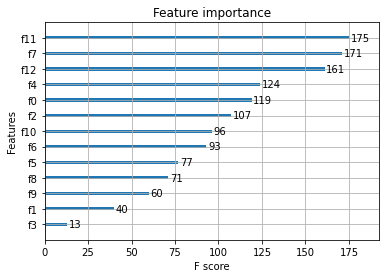

In [15]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12,12]

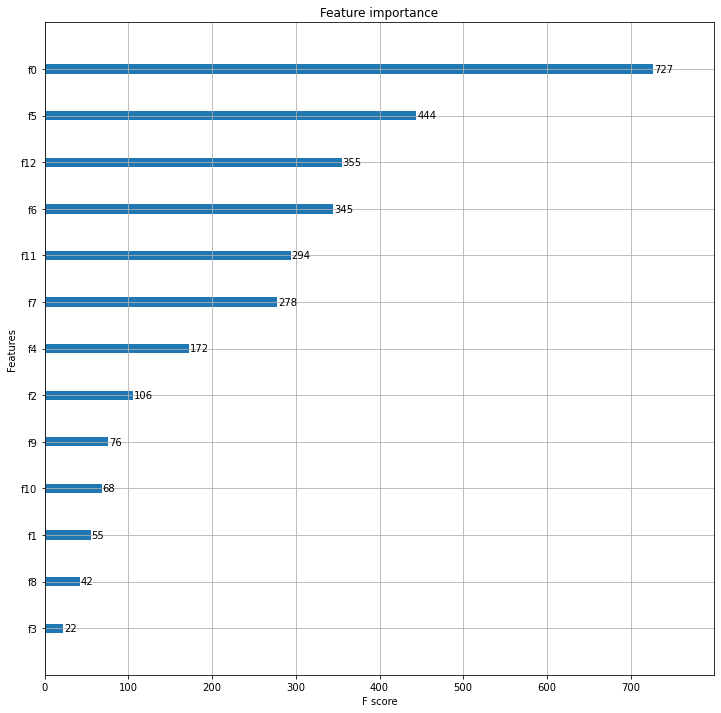

In [16]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [12, 12]

ImportError: You must install graphviz to plot tree

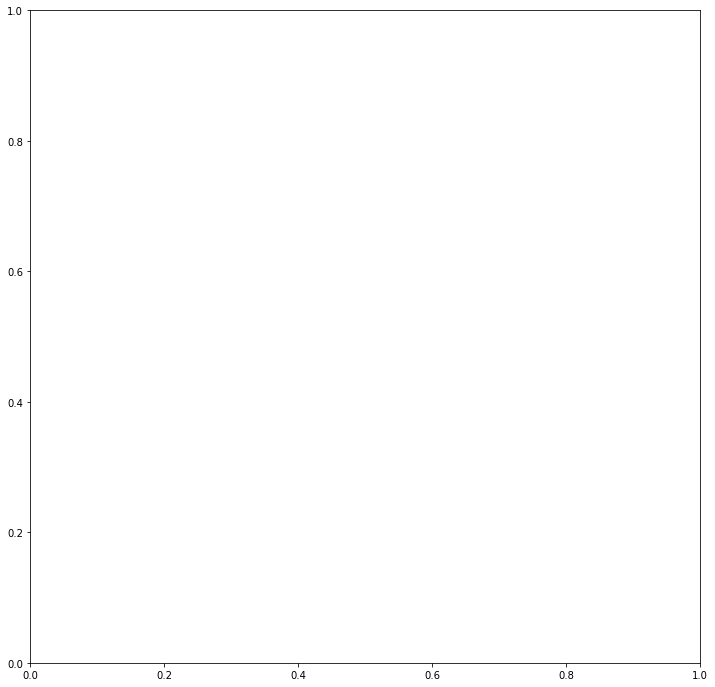

In [17]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]

In [ ]:

xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]


### XGBoost Classification

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [ ]:
diabetes = pd.read_csv("diabetes.csv")
diabetes.tail()

In [ ]:
X = diabetes.iloc[:,0:8]
y = diabetes.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify = y,test_size = 0.25, random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# fit model for training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
model.get_params()

In [ ]:
# make predictions for test data
yhat = model.predict(X_test)
cm = confusion_matrix(y_test,yhat)
cm

In [ ]:
accuracy = accuracy_score(y_test, yhat)
print("Accuracy: ", accuracy)